In [38]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import torch
from torch import nn
from torch import optim

from ncps.wirings import AutoNCP
from ncps.torch import CfC
from ncps.wirings import NCP
import pytorch_lightning as pl
import torch
import torch.utils.data as data

import seaborn as sns
sns.set()

In [39]:
# LightningModule for training a RNNSequence module
class SequenceLearner(pl.LightningModule):
    def __init__(self, model, lr=0.005):
        super().__init__()
        self.model = model
        self.lr = lr

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)

        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

In [40]:
# initialize environment
env = gym.make("Pendulum-v1", render_mode=None)
obs_space_size = env.observation_space.shape[0]
action_space_size = env.action_space.shape[0]

In [41]:
def random_rollout(env, device):
    state, _ = env.reset()
    terminated, truncated = False, False

    states_actions = []

    while not terminated and not truncated:
        # if len(states_actions) >= 5: break

        action = env.action_space.sample()
        next_state, _, terminated, truncated, _ = env.step(action)

        states_actions.append(np.concatenate((state, action)))

        state = next_state
    
    states_actions = torch.FloatTensor(np.array(states_actions))

    return states_actions

In [42]:
def collect_samples(env, n_iter, normalize_velocity=True):
    states_actions = []

    # Collect Data
    for i in range(n_iter):
        states_actions.append(random_rollout(env, "cpu"))

    states_actions = torch.stack(states_actions)

    # Normalize velocity between -1 and 1
    if normalize_velocity:
        states_actions[:,:,2] /= 8

    return states_actions

In [43]:
def get_sequences_from_data(data, sequence_length):
    output = []

    for i in range(len(data) - sequence_length + 1):

        sequence = data[i: i + sequence_length]
        output.append(sequence)
    
    output = torch.stack(output, dim=0)

    return output

In [44]:
n_iter = 100
states_actions = collect_samples(env, n_iter)
states_actions.shape

next_states = states_actions[:,1:,:3]
states_actions = states_actions[:,:-1,:]

next_states.shape, states_actions.shape

(torch.Size([100, 199, 3]), torch.Size([100, 199, 4]))

In [45]:
sequenced_input = []
sequenced_output = []
for i in range(n_iter):
    sequenced_input.append(get_sequences_from_data(states_actions[i], 15))
    sequenced_output.append(get_sequences_from_data(next_states[i], 15))

input = torch.concatenate(sequenced_input, dim=0)
output = torch.concatenate(sequenced_output, dim=0)
input.shape, output.shape

(torch.Size([18500, 15, 4]), torch.Size([18500, 15, 3]))

In [46]:
dataloader = data.DataLoader(
    data.TensorDataset(input, output), batch_size=256, shuffle=True, num_workers=4
)

In [47]:
out_features = 3
in_features = 4

wiring = NCP(inter_neurons=5, command_neurons=3, motor_neurons=out_features,
            sensory_fanout=5, inter_fanout=2, recurrent_command_synapses=0, motor_fanin=2)

ncps_model = CfC(in_features, wiring, batch_first=True, return_sequences=True, activation = "tanh", mixed_memory=True)

learn = SequenceLearner(ncps_model, lr=0.01)
trainer = pl.Trainer(
    logger=pl.loggers.CSVLogger("log"),
    max_epochs=200,
    gradient_clip_val=1
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


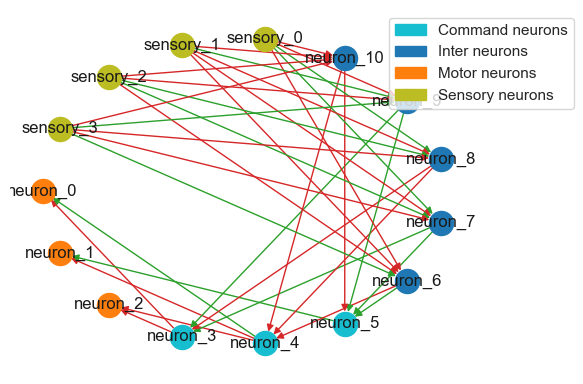

In [48]:
sns.set_style("white")
plt.figure(figsize=(6, 4))
legend_handles = wiring.draw_graph(draw_labels=True, neuron_colors={"command": "tab:cyan"})
plt.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(1, 1))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

In [49]:
trainer.fit(learn, dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | CfC  | 1.2 K  | train
---------------------------------------
1.1 K     Trainable params
87        Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


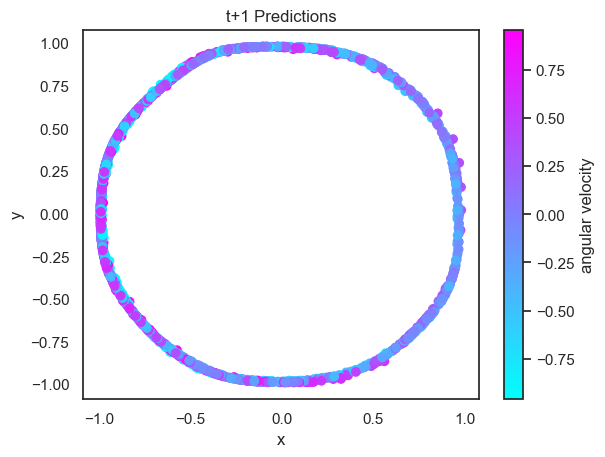

In [54]:
n_iter = 10
states_actions = collect_samples(env, n_iter).reshape(-1, 1, 4)

with torch.no_grad():
    preds = ncps_model(states_actions)[0]

preds = preds.reshape(-1, 3)
sc = plt.scatter(preds[:,0], preds[:,1], c=preds[:,2], cmap="cool")
plt.colorbar(sc, label="angular velocity")
plt.title("t+1 Predictions")
plt.xlabel("x")
plt.ylabel("y");

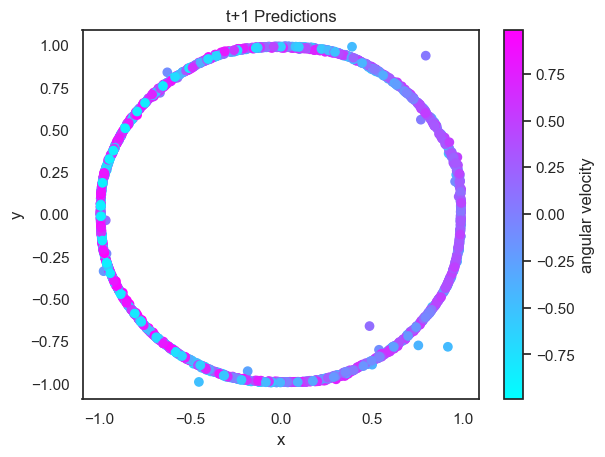

In [55]:
n_iter = 10
states_actions = collect_samples(env, n_iter).reshape(1, -1, 4)

with torch.no_grad():
    preds = ncps_model(states_actions)[0]

preds = preds.reshape(-1, 3)
sc = plt.scatter(preds[:,0], preds[:,1], c=preds[:,2], cmap="cool")
plt.colorbar(sc, label="angular velocity")
plt.title("t+1 Predictions")
plt.xlabel("x")
plt.ylabel("y");

In [56]:
def ncps_rollout(model, n_iter, horizon, states_actions=None):

    # Collect Data
    if states_actions is None:
        states_actions = collect_samples(env, n_iter, normalize_velocity=True)

    # Start with same start states
    input = states_actions[:,0,:]
    ht = None

    # Predict Trajectories
    preds = []
    for i in range(horizon):
        input = input.reshape(n_iter, 1, 4)

        with torch.no_grad():
            pred, ht = model(input, ht)

        input = torch.concatenate((pred.reshape(n_iter, 1, 3), states_actions[:, i, 3].reshape(n_iter, 1, 1)), dim=2)
        preds.append(pred)

    preds = torch.stack(preds).transpose(0, 1).squeeze(dim=2) # dim 2 is the sequence

    return preds, states_actions

n_iter = 150
horizon = 199
preds, states_actions = ncps_rollout(ncps_model, n_iter, horizon)

print(f"{preds.shape = }")
print(f"{states_actions.shape = }")

preds.shape = torch.Size([150, 199, 3])
states_actions.shape = torch.Size([150, 200, 4])


In [57]:
def plot_feature_trajectory(ax, feature, title, n_iter, horizon, color="blue", plot_individual=True):
    if plot_individual:
        for i in range(n_iter):
            ax.plot(feature[i, :], alpha = 0.05, color="gray")
    
    avg = torch.mean(feature, dim=0)
    std = torch.std(feature, axis=0)
    ax.plot(avg, color=color, label=title + " mean")
    ax.fill_between(
        np.arange(horizon),
        avg - std,
        avg + std,
        color=color, alpha=0.3,
        label=title + '± 1 Std Dev'
    )
    ax.legend(loc="upper left")

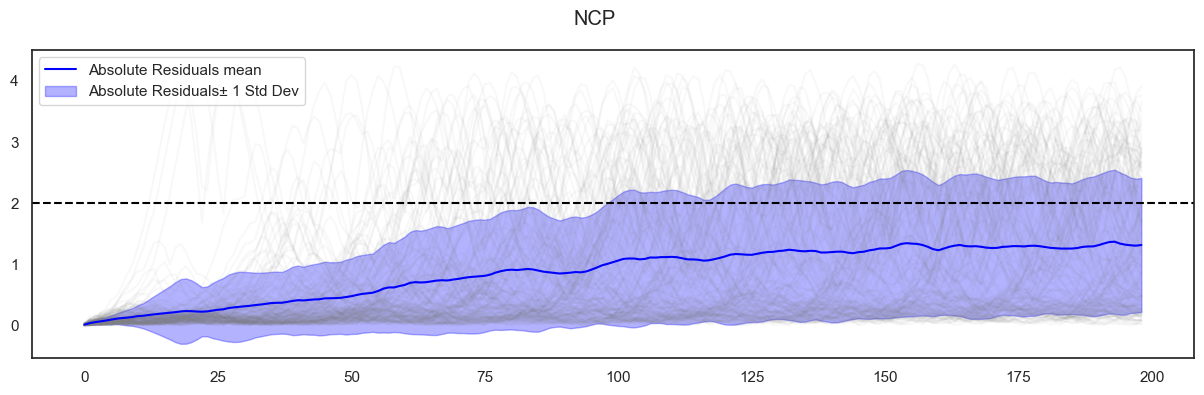

In [60]:
# Plot Data
fig, axs = plt.subplots(1, 1, figsize=(15, 4))

lengths = torch.sqrt(preds[:, :, 0] ** 2 + preds[:, :, 1] ** 2)
residuals = states_actions[:, 1:horizon + 1, :3] - preds
sum_residuals = residuals.abs().sum(dim=2)

fig.suptitle("NCP")

plot_feature_trajectory(axs, sum_residuals, "Absolute Residuals", n_iter, horizon)
axs.axhline(2, c="black", linestyle="dashed") # Dummy Line